# Growth Mechanism with Details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [3]:
para_path = 'F:/UMich/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
ds_para.data_info

Growth: temp250:
--spot: spot_1:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 22, 10)
----reconstructed_image:, Size of data: (499922, 22, 10)
----width_x:, Size of data: (499922,)
----width_y:, Size of data: (499922,)
----x:, Size of data: (499922,)
----y:, Size of data: (499922,)
--spot: spot_2:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 29, 13)
----reconstructed_image:, Size of data: (499922, 29, 13)
----width_x:, Size of data: (499922,)
----wid

## 2. Analyze the Decay Curve

### 2.1 J14-300C

temp250


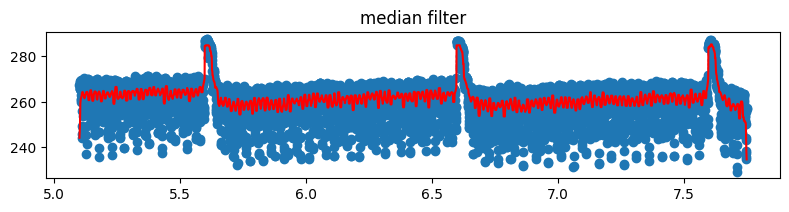

temp300


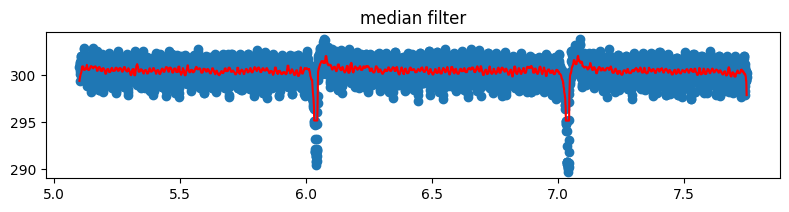

temp350


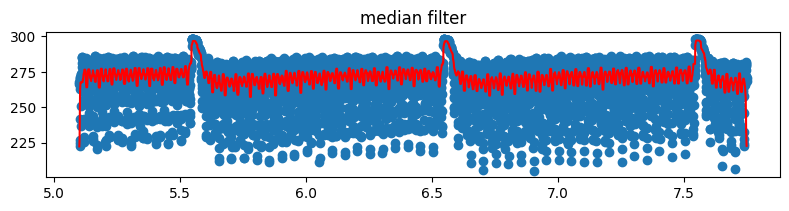

In [5]:
for temp in ['temp250', 'temp300', 'temp350']:
    x, y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    sample_x, sample_y = x[10200:15500], y[10200:15500]
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

('img_rec_sum', 'spot_2')


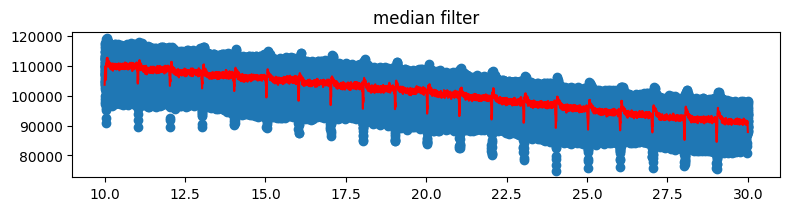

('img_rec_max', 'spot_2')


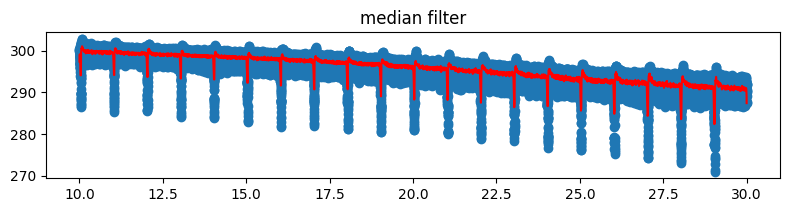

('height', 'spot_2')


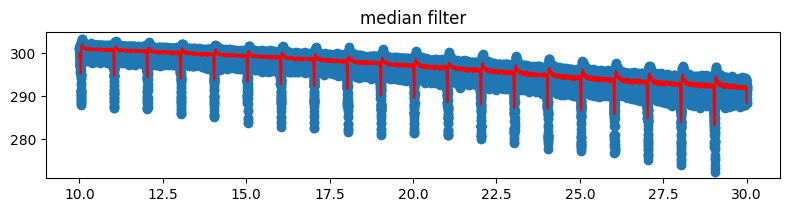

('x', 'spot_1')


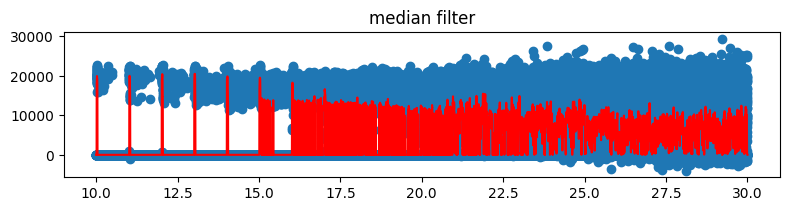

In [18]:
ranges_list = [(0, 20), (0, 20), (0, 20), (0, 20)]
m_spot_list = [("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp300', spot=spot, metric=m, x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, 10, 30)
    sample_x, sample_y = data[:, 0], data[:, 1]
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

temp250


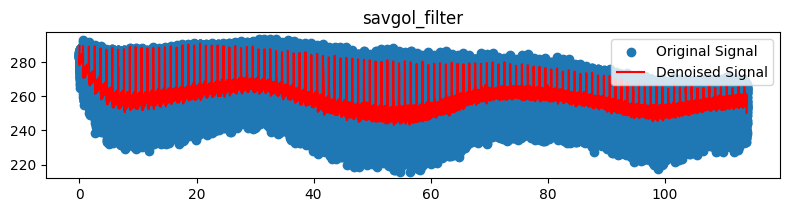

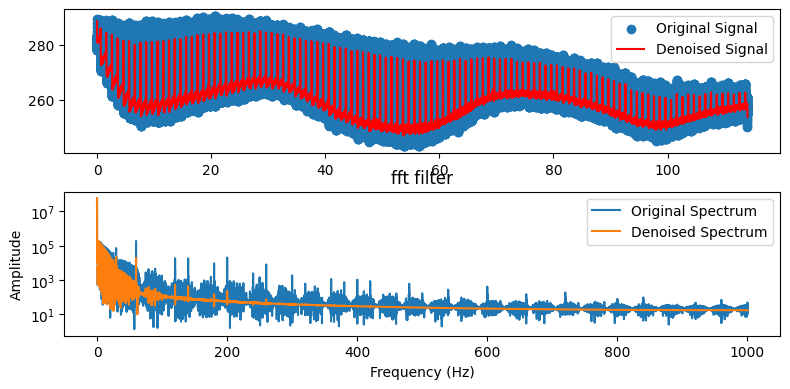

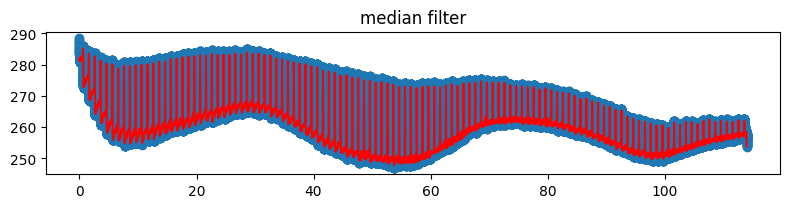

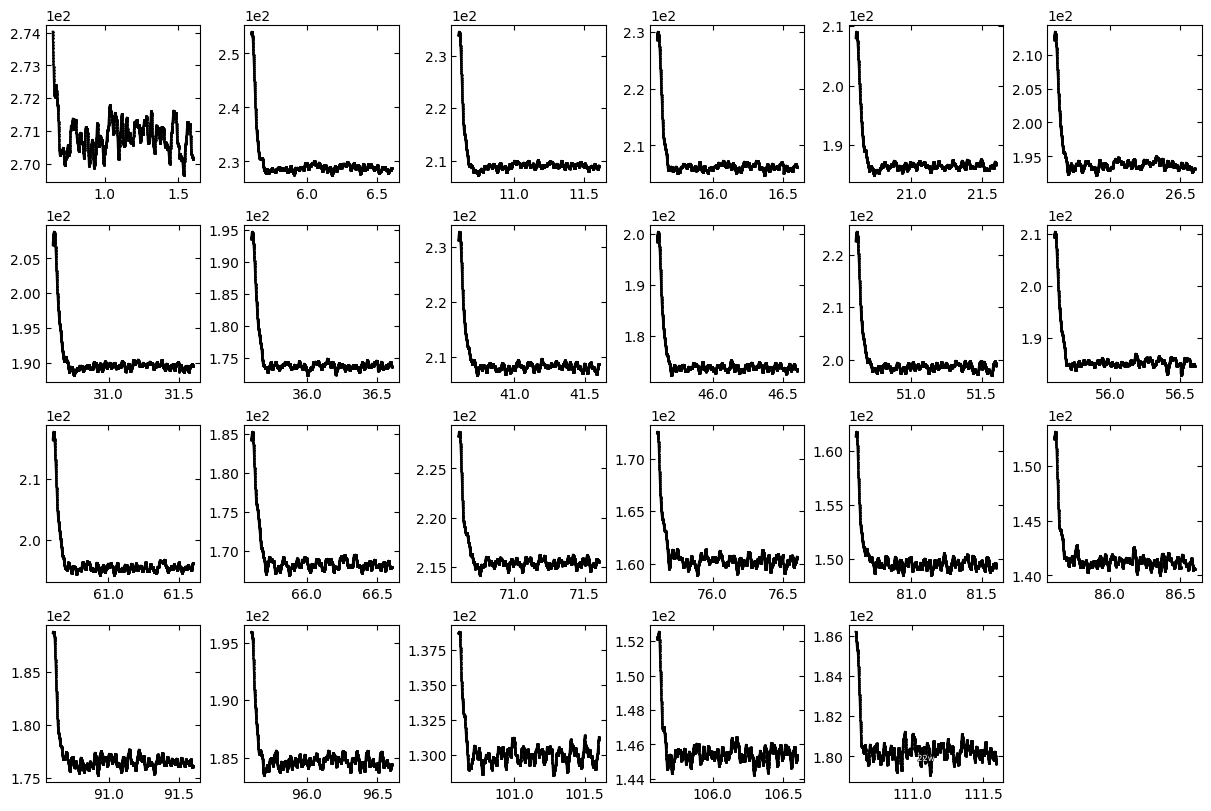

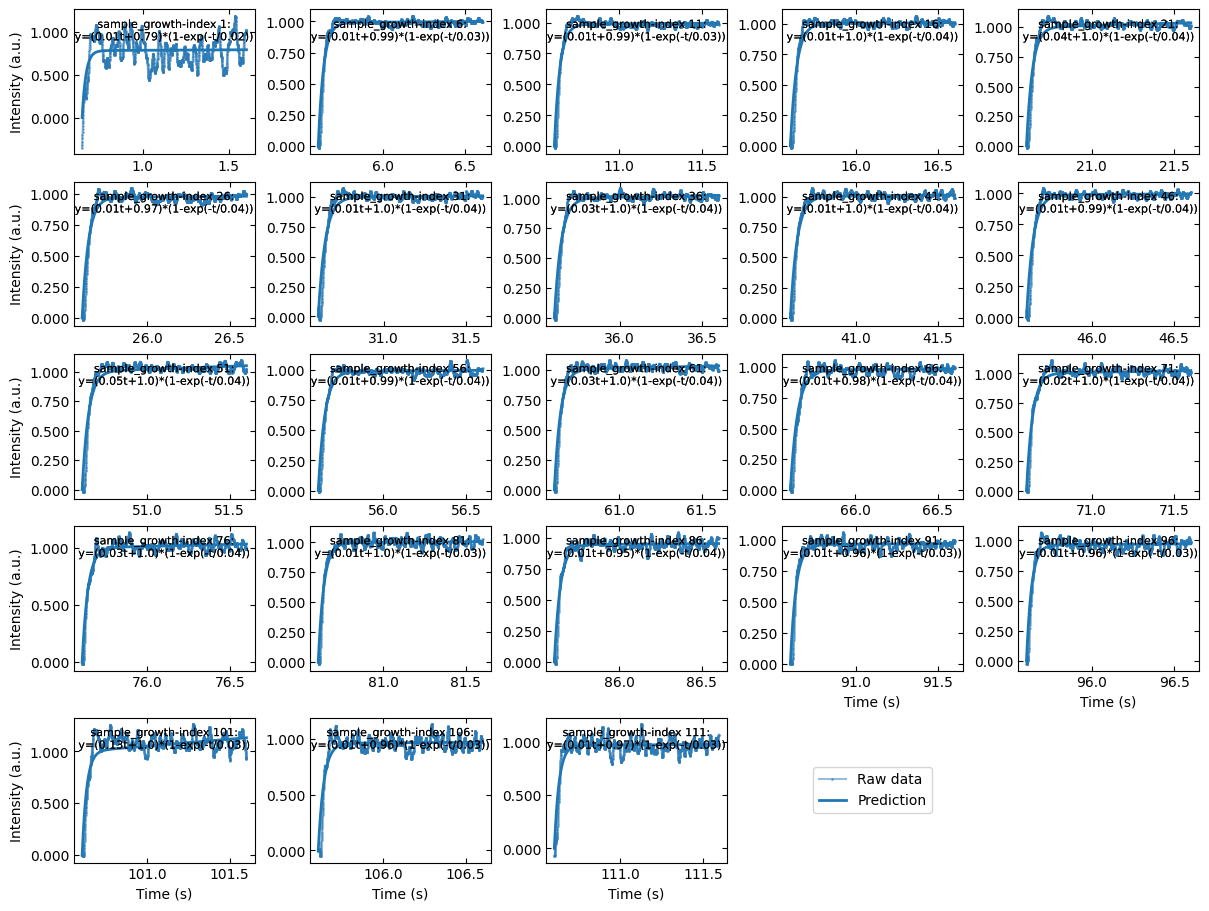

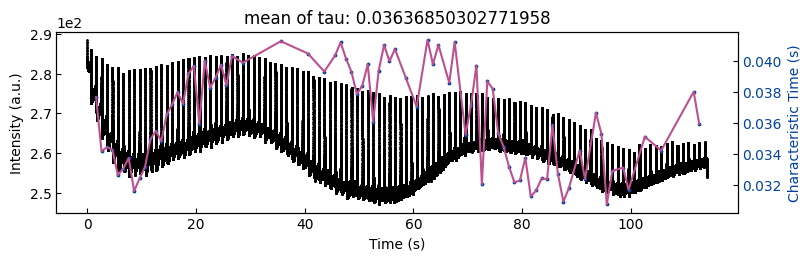

temp300


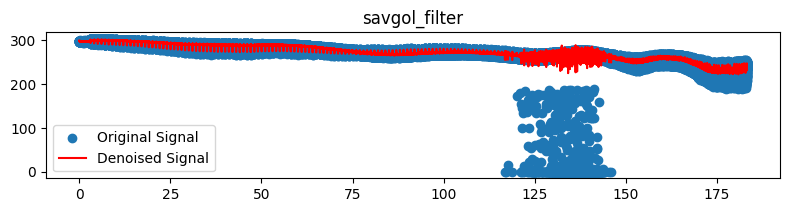

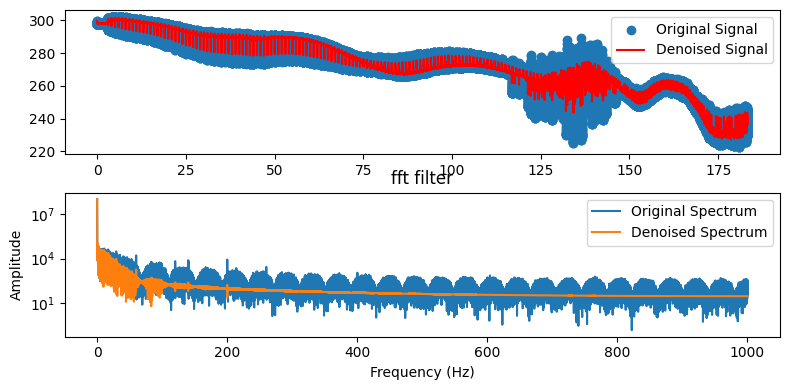

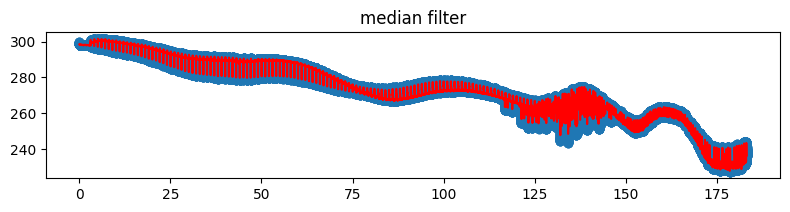

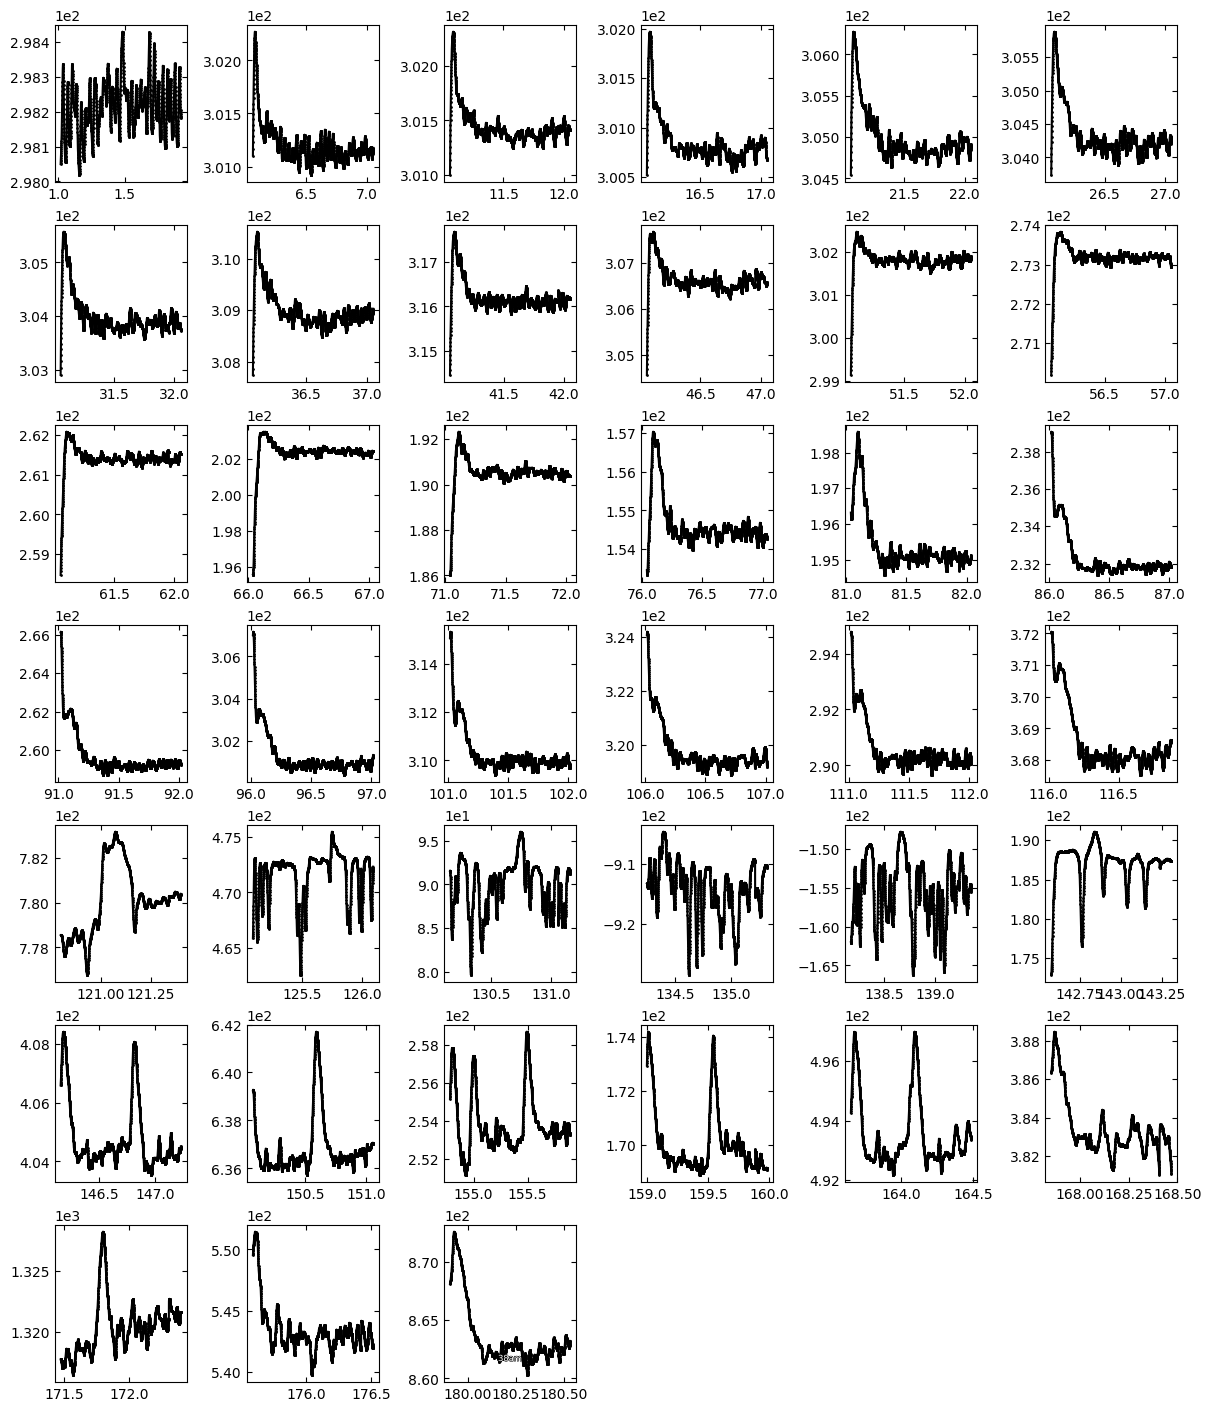

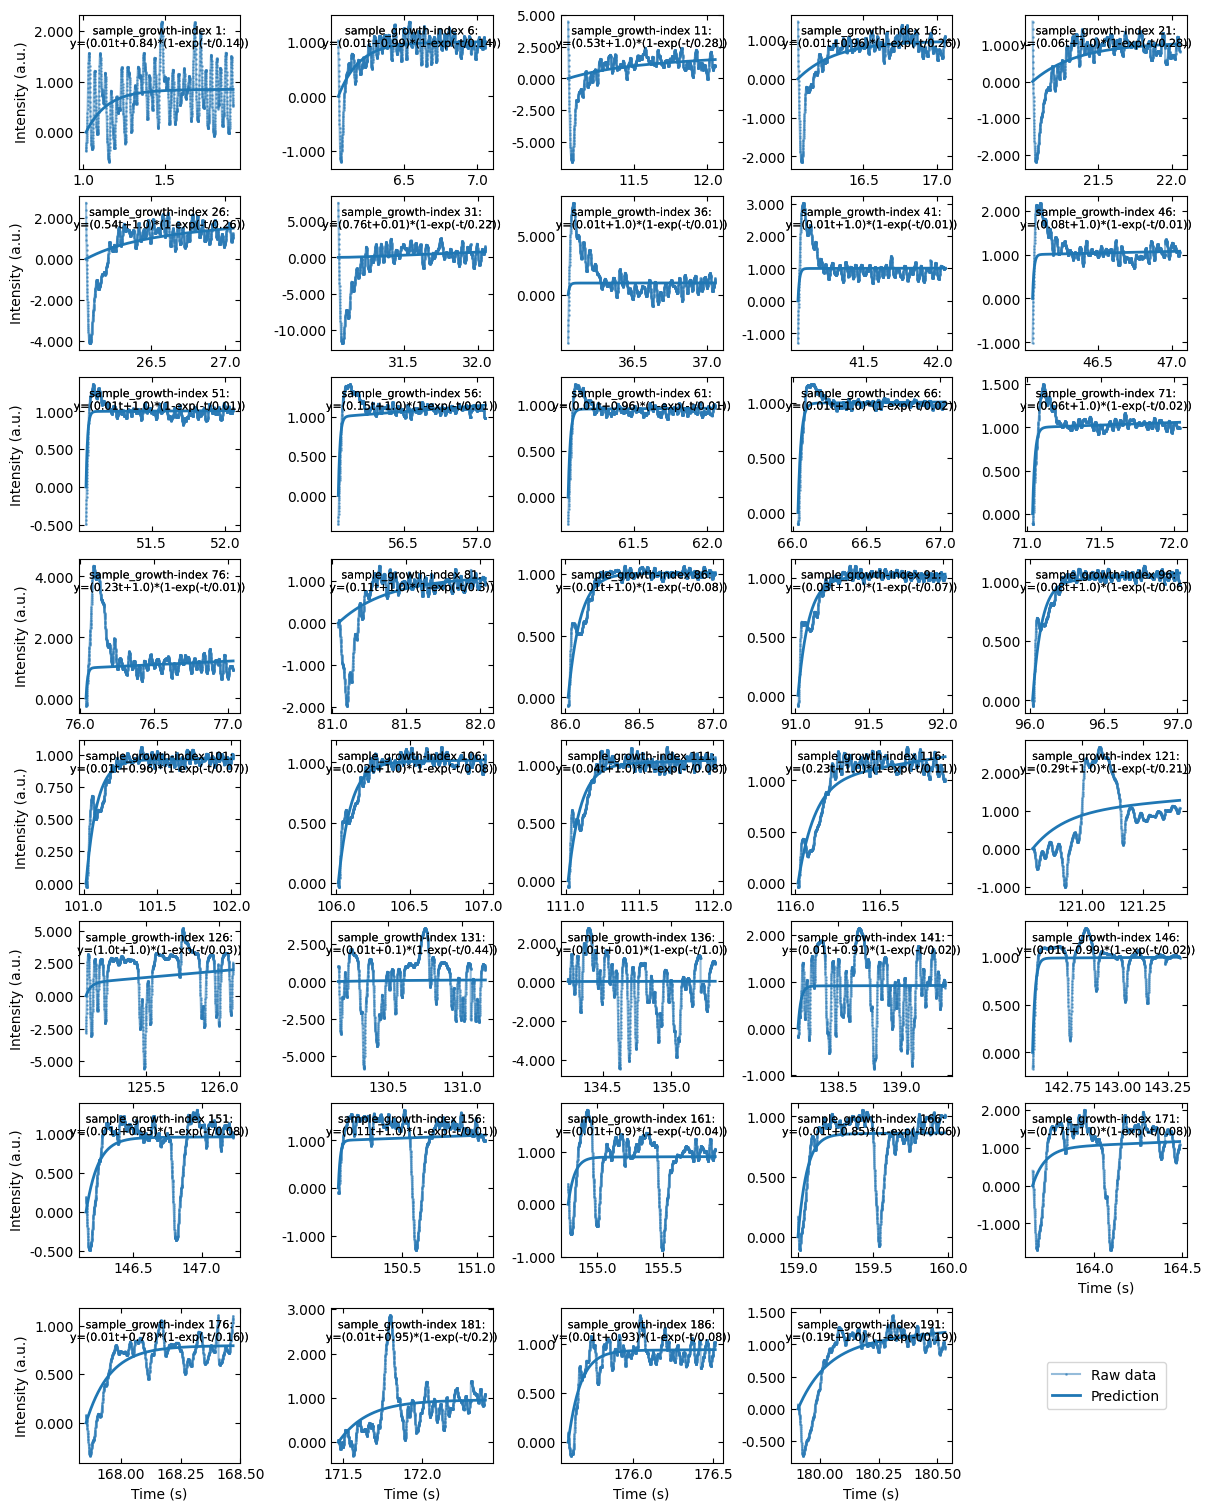

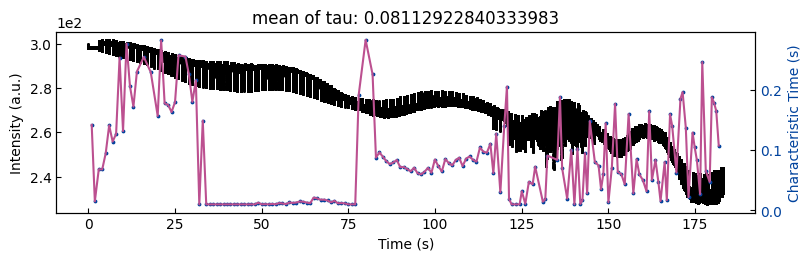

temp350


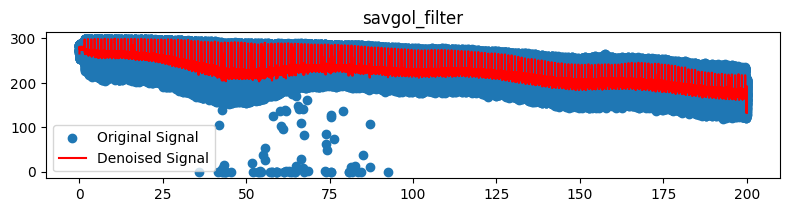

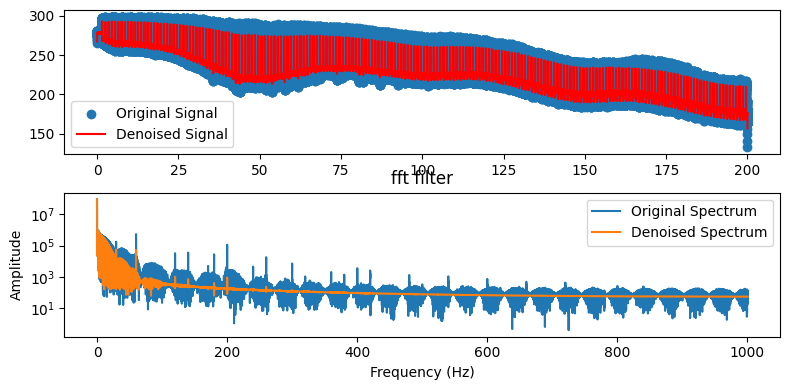

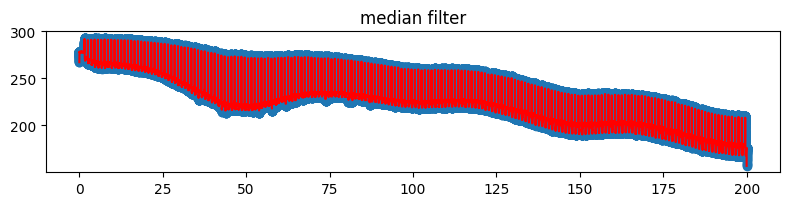

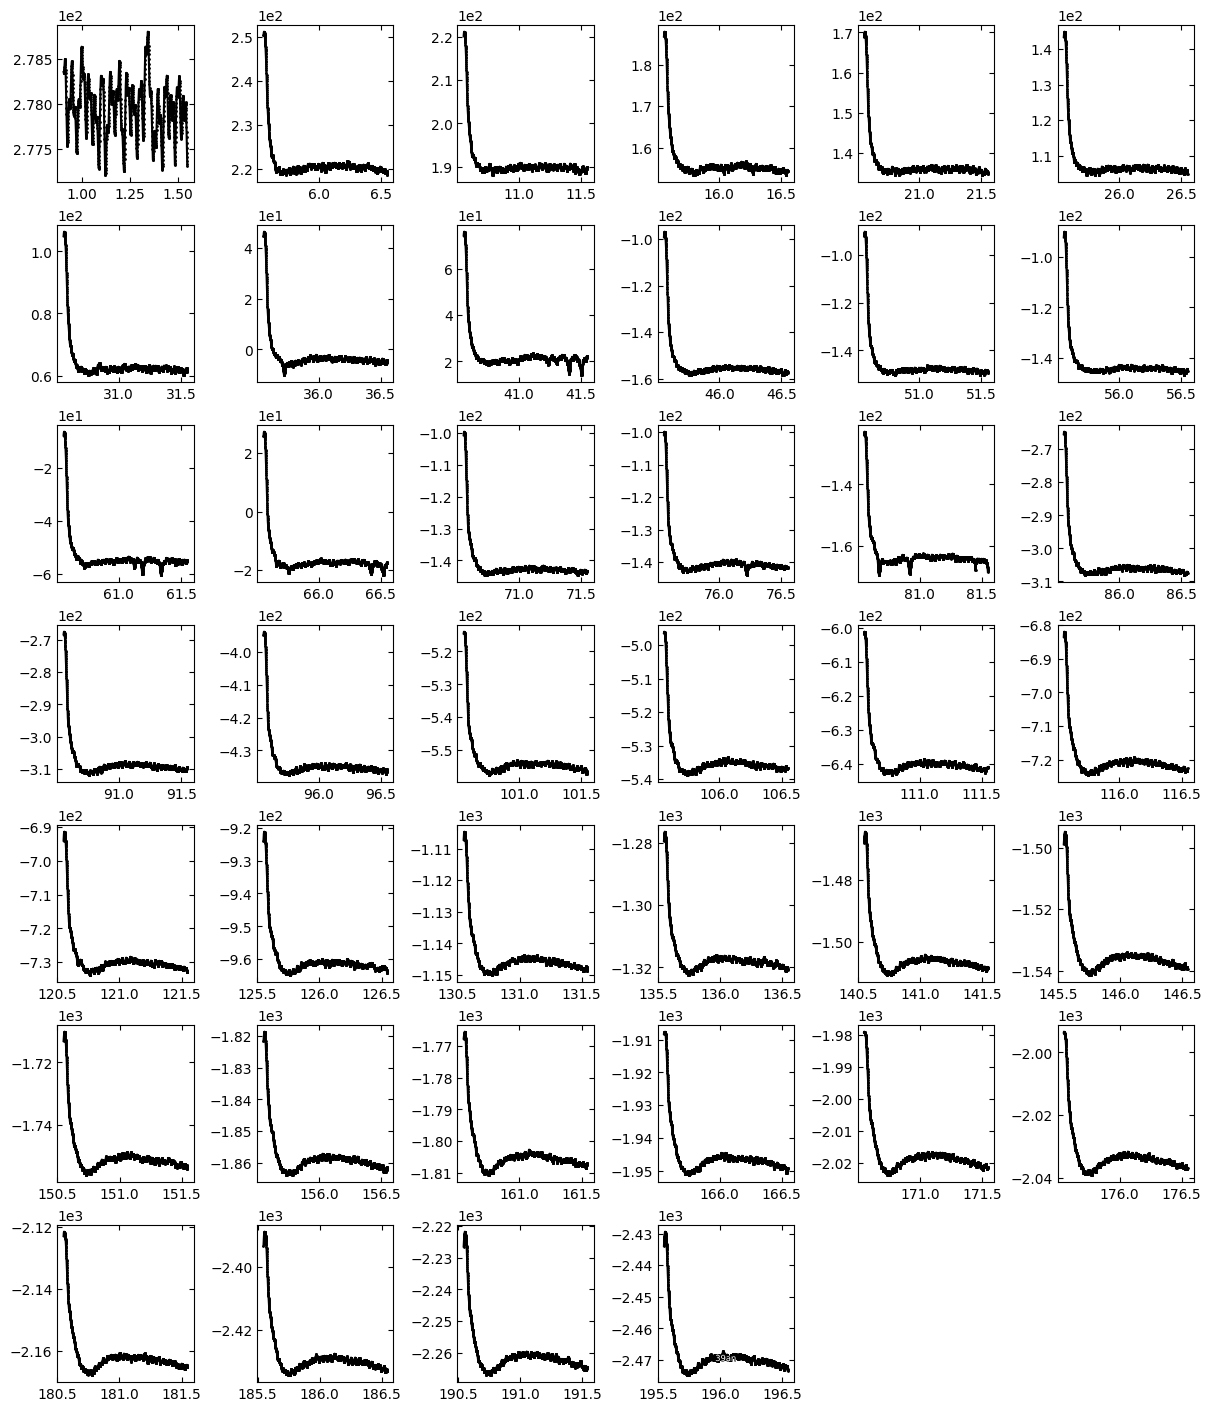

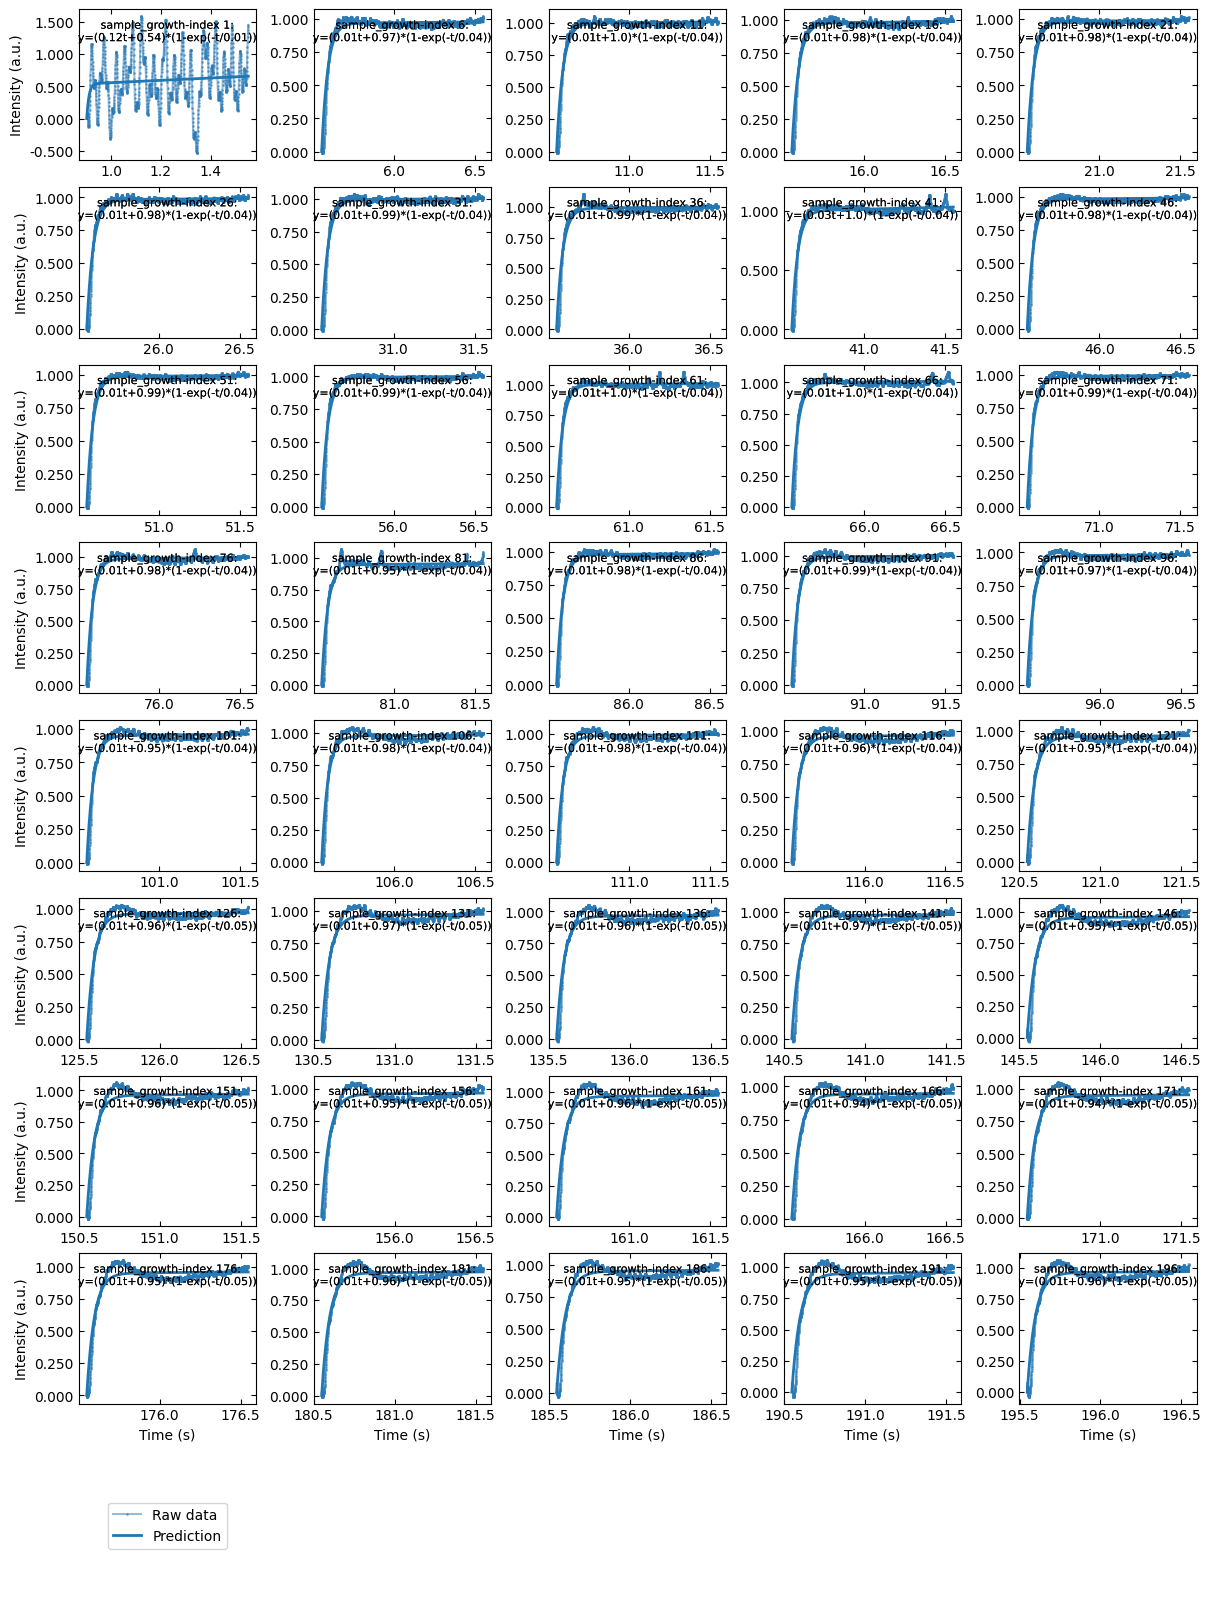

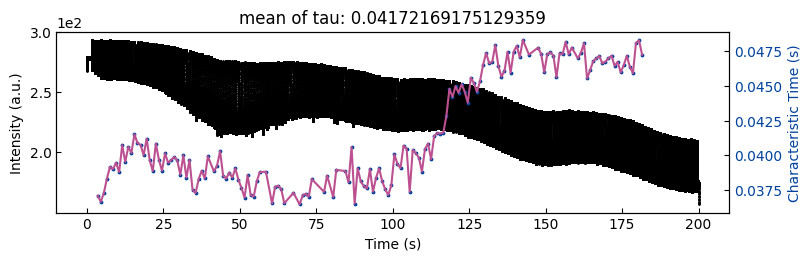

In [10]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)

temp250


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.array(ys

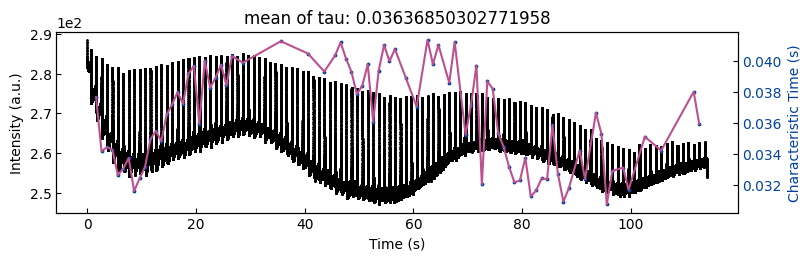

temp300


c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


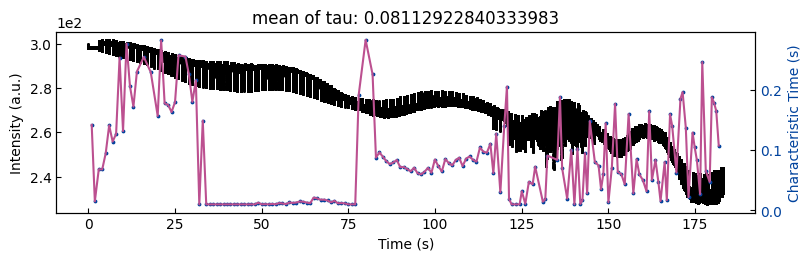

temp350


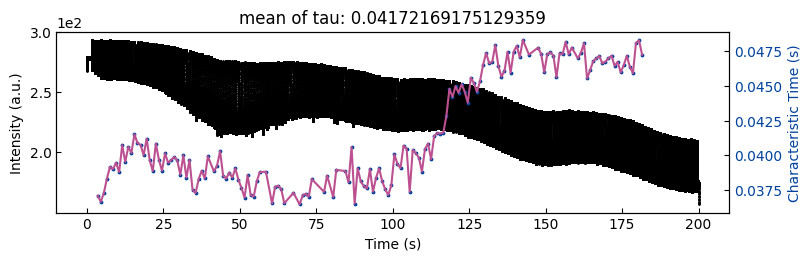

In [20]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']
T_list, tau_list = [250, 300, 350], []
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    tau_list.append(tau)

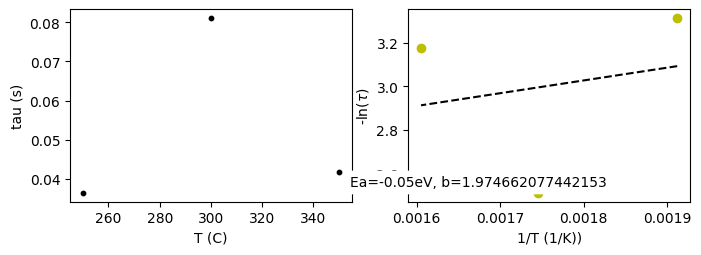

In [21]:
plot_activation_energy(T_list, tau_list)